# Model Interpretability - Decision Paths, PDPs, and Confidence Analysis

**Objective:** Deep dive into model decision-making through visualization and analysis of prediction mechanisms.

**Inputs:**

- Features with regimes from notebook 30 (`AAPL_features_with_regimes.parquet`)
- Trained models from notebooks 40, 45, 50
- Feature importance results from notebook 60
- **Time period:** December 9-13, 2024 (5 trading days)

**Methods:**

- **Decision path analysis:** Visualize tree structures and extract IF-THEN rules
- **Partial Dependence Plots (PDPs):** Marginal effect of features on predictions
- **Individual Conditional Expectation (ICE):** Feature effects for individual samples
- **Model confidence analysis:** Prediction probability distributions and calibration
- **Confidence-stratified accuracy:** Performance at different confidence levels

**Analyses:**

- Which decision rules does the tree use most frequently?
- How do top features affect predictions (linear, non-linear, threshold effects)?
- What's the joint effect of feature pairs?
- How well-calibrated are the model's confidence scores?
- Should we filter low-confidence predictions?

**Outputs:**

- Decision tree visualizations with decision paths
- Extracted IF-THEN rules from trees
- 1D partial dependence plots (top features)
- 2D partial dependence plots (feature interactions)
- ICE plots showing heterogeneous effects
- Calibration curves (predicted vs. actual probabilities)
- Confidence-stratified performance metrics

**Key Question:** How do our models make predictions, and can we trust their confidence scores?


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.tree import plot_tree, export_text
from sklearn.inspection import (
    partial_dependence,
    PartialDependenceDisplay,
)
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    brier_score_loss,
)

# Visualization
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

# Import project config
import sys

sys.path.append("..")
from src.config import PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR, TABLES_DIR

# Create output directories
interp_dir = FIGURES_DIR / "interpretability"
interp_dir.mkdir(parents=True, exist_ok=True)

# Set random seed
np.random.seed(42)

print(" Setup complete")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Figures directory: {interp_dir}")

 Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed
  Models directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models
  Figures directory: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability


In [2]:
# Configuration
TICKER = "AAPL"
START_DATE = "2024-12-09"
END_DATE = "2024-12-13"
DATE_RANGE = f"{START_DATE}_to_{END_DATE}"

print(f"Configuration:")
print(f"  Ticker: {TICKER}")
print(f"  Date range: {START_DATE} to {END_DATE}")
print(f"  Trading days: 5")

Configuration:
  Ticker: AAPL
  Date range: 2024-12-09 to 2024-12-13
  Trading days: 5


## 2. Load Data and Models


In [3]:
# Load features with regimes
print("Loading features with regimes...")
features_with_regimes = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_features_with_regimes.parquet"
).reset_index(drop=True)

print(f" Features with regimes: {features_with_regimes.shape}")

# Load trained models
print("\nLoading trained models...")

with open(MODELS_DIR / "decision_tree_tuned.pkl", "rb") as f:
    dt_model = pickle.load(f)
print("   Decision Tree")

with open(MODELS_DIR / "random_forest_tuned.pkl", "rb") as f:
    rf_model = pickle.load(f)
print("   Random Forest")

with open(MODELS_DIR / "gradient_boosting_tuned.pkl", "rb") as f:
    gb_model = pickle.load(f)
print("   Gradient Boosting")

# Load feature importance results
with open(MODELS_DIR / "feature_importance_results.json", "r") as f:
    fi_results = json.load(f)
print("  ✓ Feature importance results")

print("\n✓ All models and results loaded")

Loading features with regimes...
 Features with regimes: (1365, 94)

Loading trained models...
   Decision Tree
   Random Forest
   Gradient Boosting
  ✓ Feature importance results

✓ All models and results loaded


## 3. Prepare Data


In [4]:
# Find price column
price_candidates = ["agg_mid_price", "agg_close", "mid_price", "close"]
price_col = next(
    (col for col in price_candidates if col in features_with_regimes.columns), None
)

if price_col is None:
    raise ValueError(f"No price column found")

print(f"Using price column: {price_col}")

# Create target
features_with_regimes["price_next"] = features_with_regimes[price_col].shift(-1)
features_with_regimes["target"] = (
    features_with_regimes["price_next"] > features_with_regimes[price_col]
).astype(int)
features_with_regimes = features_with_regimes[:-1].copy()

# Columns to exclude from features
exclude_cols = [
    "timestamp",
    "target",
    "price_next",
    "regime_hmm",
    "regime_hawkes",
    "regime_hawkes_binary",
    "hmm_state",
    "time_hour",
    "time_minute",
    "time_minutes_since_open",
    "time_session",
    "hour",
    "minute",
    "time_of_day",
]

# Get feature columns
feature_cols = [col for col in features_with_regimes.columns if col not in exclude_cols]

# Select only numeric features
X = features_with_regimes[feature_cols].select_dtypes(include=[np.number])
feature_cols = X.columns.tolist()

# Get target
y = features_with_regimes["target"].values

# Handle missing and infinite values
X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\n Feature matrix: {X.shape}")
print(f" Target vector: {y.shape}")
print(f" Features: {len(feature_cols)}")

Using price column: agg_mid_price

 Feature matrix: (1364, 81)
 Target vector: (1364,)
 Features: 81


In [5]:
# Train-test split (same as model training)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Get predictions and probabilities
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

print("\n Predictions generated for all models")

Train set: 1,091 samples
Test set: 273 samples

 Predictions generated for all models


## 4. Decision Tree Visualization

Visualize the decision tree structure to understand the rules it learned.


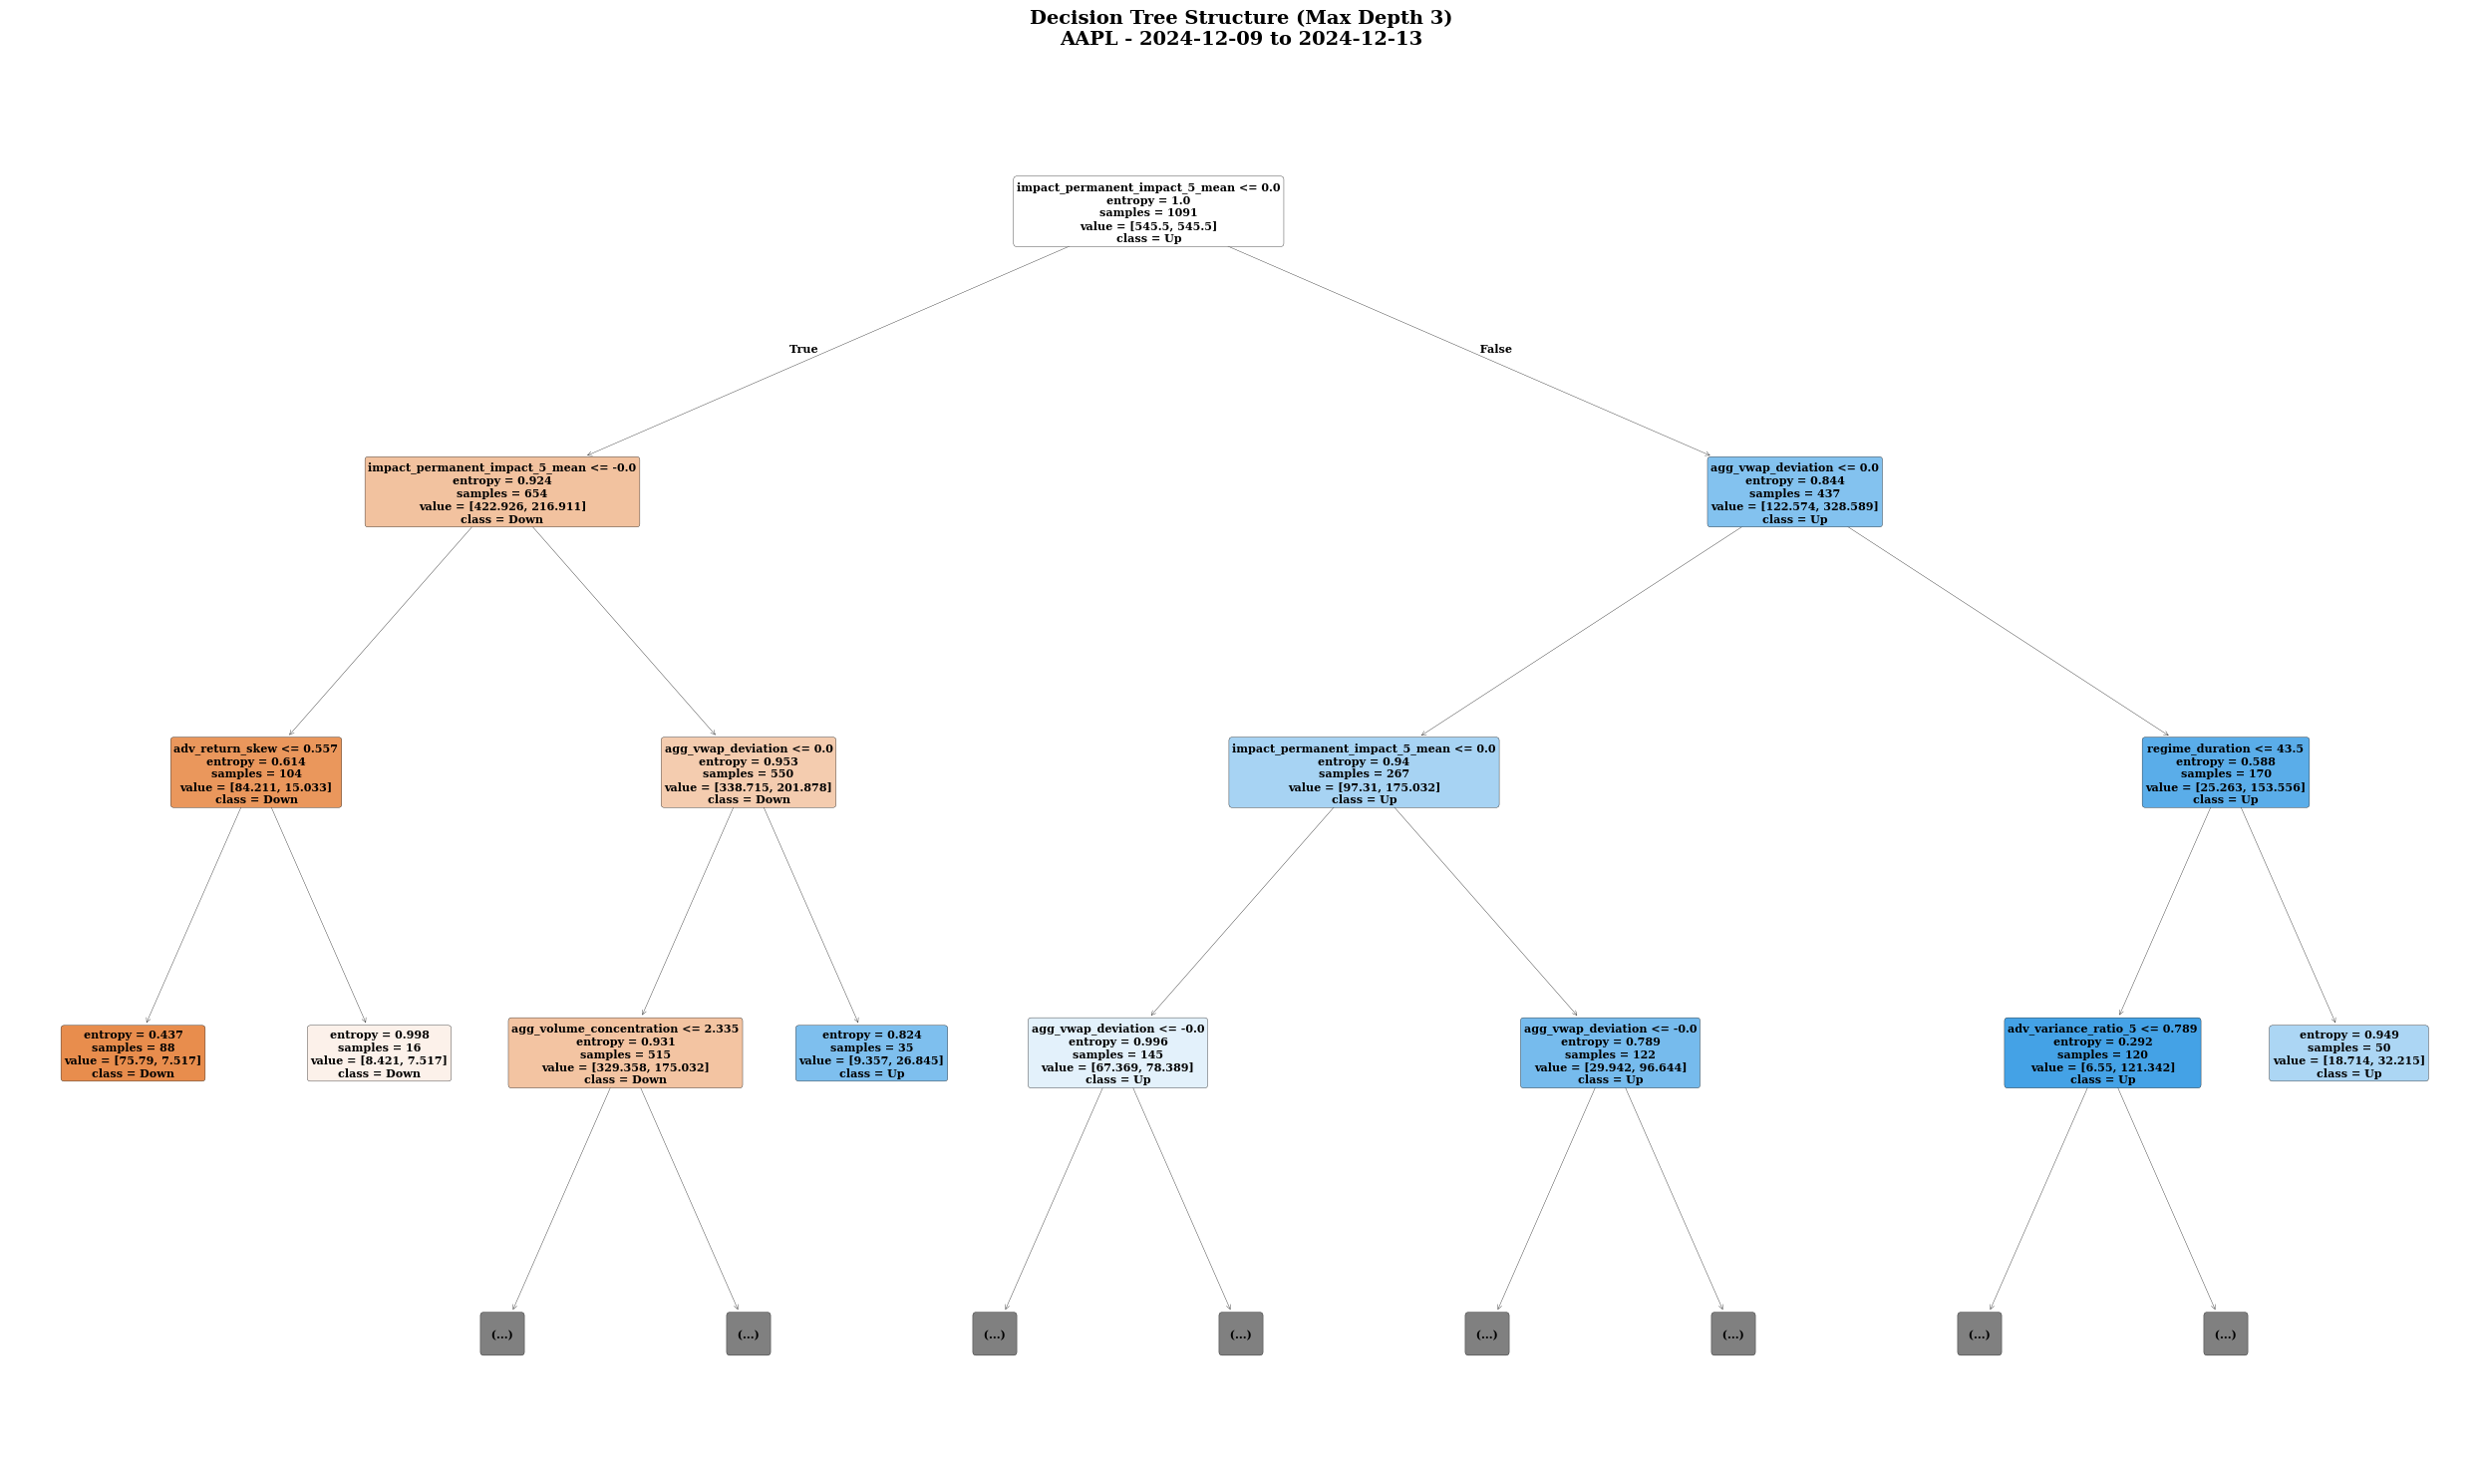


 Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability/decision_tree_structure.png

Tree properties:
  Max depth: 7
  Number of leaves: 16
  Total nodes: 31


In [6]:
# Visualize decision tree
fig, ax = plt.subplots(figsize=(25, 15))

plot_tree(
    dt_model,
    feature_names=feature_cols,
    class_names=["Down", "Up"],
    filled=True,
    rounded=True,
    fontsize=8,
    ax=ax,
    max_depth=3,  # Limit depth for readability
)

ax.set_title(
    f"Decision Tree Structure (Max Depth 3)\n{TICKER} - {START_DATE} to {END_DATE}",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

plt.tight_layout()
plt.savefig(interp_dir / "decision_tree_structure.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {interp_dir / 'decision_tree_structure.png'}")
print(f"\nTree properties:")
print(f"  Max depth: {dt_model.max_depth}")
print(f"  Number of leaves: {dt_model.get_n_leaves()}")
print(f"  Total nodes: {dt_model.tree_.node_count}")

## 5. Extract Decision Rules

Convert decision tree paths to human-readable IF-THEN rules.


In [7]:
# Extract text representation of tree rules
tree_rules = export_text(dt_model, feature_names=feature_cols, max_depth=4)

print("=" * 80)
print("DECISION TREE RULES (First 4 Levels)")
print("=" * 80)
print(tree_rules[:3000])  # Print first 3000 characters
print("...\n[Truncated for brevity]")

# Save full rules to file
with open(TABLES_DIR / "decision_tree_rules.txt", "w") as f:
    f.write(tree_rules)

print(f"\n Full rules saved to {TABLES_DIR / 'decision_tree_rules.txt'}")

DECISION TREE RULES (First 4 Levels)
|--- impact_permanent_impact_5_mean <= 0.00
|   |--- impact_permanent_impact_5_mean <= -0.00
|   |   |--- adv_return_skew <= 0.56
|   |   |   |--- class: 0
|   |   |--- adv_return_skew >  0.56
|   |   |   |--- class: 0
|   |--- impact_permanent_impact_5_mean >  -0.00
|   |   |--- agg_vwap_deviation <= 0.00
|   |   |   |--- agg_volume_concentration <= 2.34
|   |   |   |   |--- trade_sell_volume <= 1739.00
|   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |--- trade_sell_volume >  1739.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- agg_volume_concentration >  2.34
|   |   |   |   |--- class: 1
|   |   |--- agg_vwap_deviation >  0.00
|   |   |   |--- class: 1
|--- impact_permanent_impact_5_mean >  0.00
|   |--- agg_vwap_deviation <= 0.00
|   |   |--- impact_permanent_impact_5_mean <= 0.00
|   |   |   |--- agg_vwap_deviation <= -0.00
|   |   |   |   |--- class: 0
|   |   |   |--- agg_vwap_deviation >  -0.00
|   |   |   |   |---

In [8]:
# Extract and analyze most common decision paths
from sklearn.tree import _tree


def extract_path_rules(tree, feature_names, sample_idx):
    """Extract decision path for a specific sample as IF-THEN rules."""
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    # Get decision path
    node_indicator = tree.decision_path(X_test)
    leaf_id = tree.apply(X_test)

    sample_id = sample_idx
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    rules = []
    for node_id in node_index:
        if leaf_id[sample_id] == node_id:
            continue

        if X_test.iloc[sample_id, tree_.feature[node_id]] <= tree_.threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        rules.append(
            f"{feature_name[node_id]} {threshold_sign} {tree_.threshold[node_id]:.4f}"
        )

    return rules


# Extract rules for a few examples
print("\n" + "=" * 80)
print("EXAMPLE DECISION PATHS")
print("=" * 80)

for i in [0, 10, 50, 100]:
    if i >= len(X_test):
        break
    rules = extract_path_rules(dt_model, feature_cols, i)
    print(f"\nSample {i}: Actual={y_test[i]}, Predicted={y_pred_dt[i]}")
    for j, rule in enumerate(rules, 1):
        print(f"  {j}. IF {rule}")
    print(f"   THEN predict: {'UP' if y_pred_dt[i] == 1 else 'DOWN'}")


EXAMPLE DECISION PATHS

Sample 0: Actual=0, Predicted=0
  1. IF impact_permanent_impact_5_mean <= 0.0000
  2. IF impact_permanent_impact_5_mean > -0.0003
  3. IF agg_vwap_deviation <= 0.0002
  4. IF agg_volume_concentration <= 2.3351
  5. IF trade_sell_volume <= 1739.0000
  6. IF cluster_inter_arrival_std > 6.7405
  7. IF impact_permanent_impact_5_mean <= -0.0001
   THEN predict: DOWN

Sample 10: Actual=0, Predicted=1
  1. IF impact_permanent_impact_5_mean > 0.0000
  2. IF agg_vwap_deviation > 0.0001
  3. IF regime_duration <= 43.5000
  4. IF adv_variance_ratio_5 <= 0.7888
   THEN predict: UP

Sample 50: Actual=1, Predicted=0
  1. IF impact_permanent_impact_5_mean <= 0.0000
  2. IF impact_permanent_impact_5_mean > -0.0003
  3. IF agg_vwap_deviation <= 0.0002
  4. IF agg_volume_concentration <= 2.3351
  5. IF trade_sell_volume <= 1739.0000
  6. IF cluster_inter_arrival_std > 6.7405
  7. IF impact_permanent_impact_5_mean <= -0.0001
   THEN predict: DOWN

Sample 100: Actual=1, Predicted=

## 6. Partial Dependence Plots (1D)

**Partial Dependence Plots** show the marginal effect of a feature on predictions, averaging over all other features.


Computing partial dependence for top 6 features:
  1. impact_permanent_impact_5_mean
  2. agg_intrabar_momentum
  3. agg_vwap_deviation
  4. trade_volume_imbalance
  5. cluster_inter_arrival_std
  6. impact_impact_per_share_mean

Computing partial dependence plots...


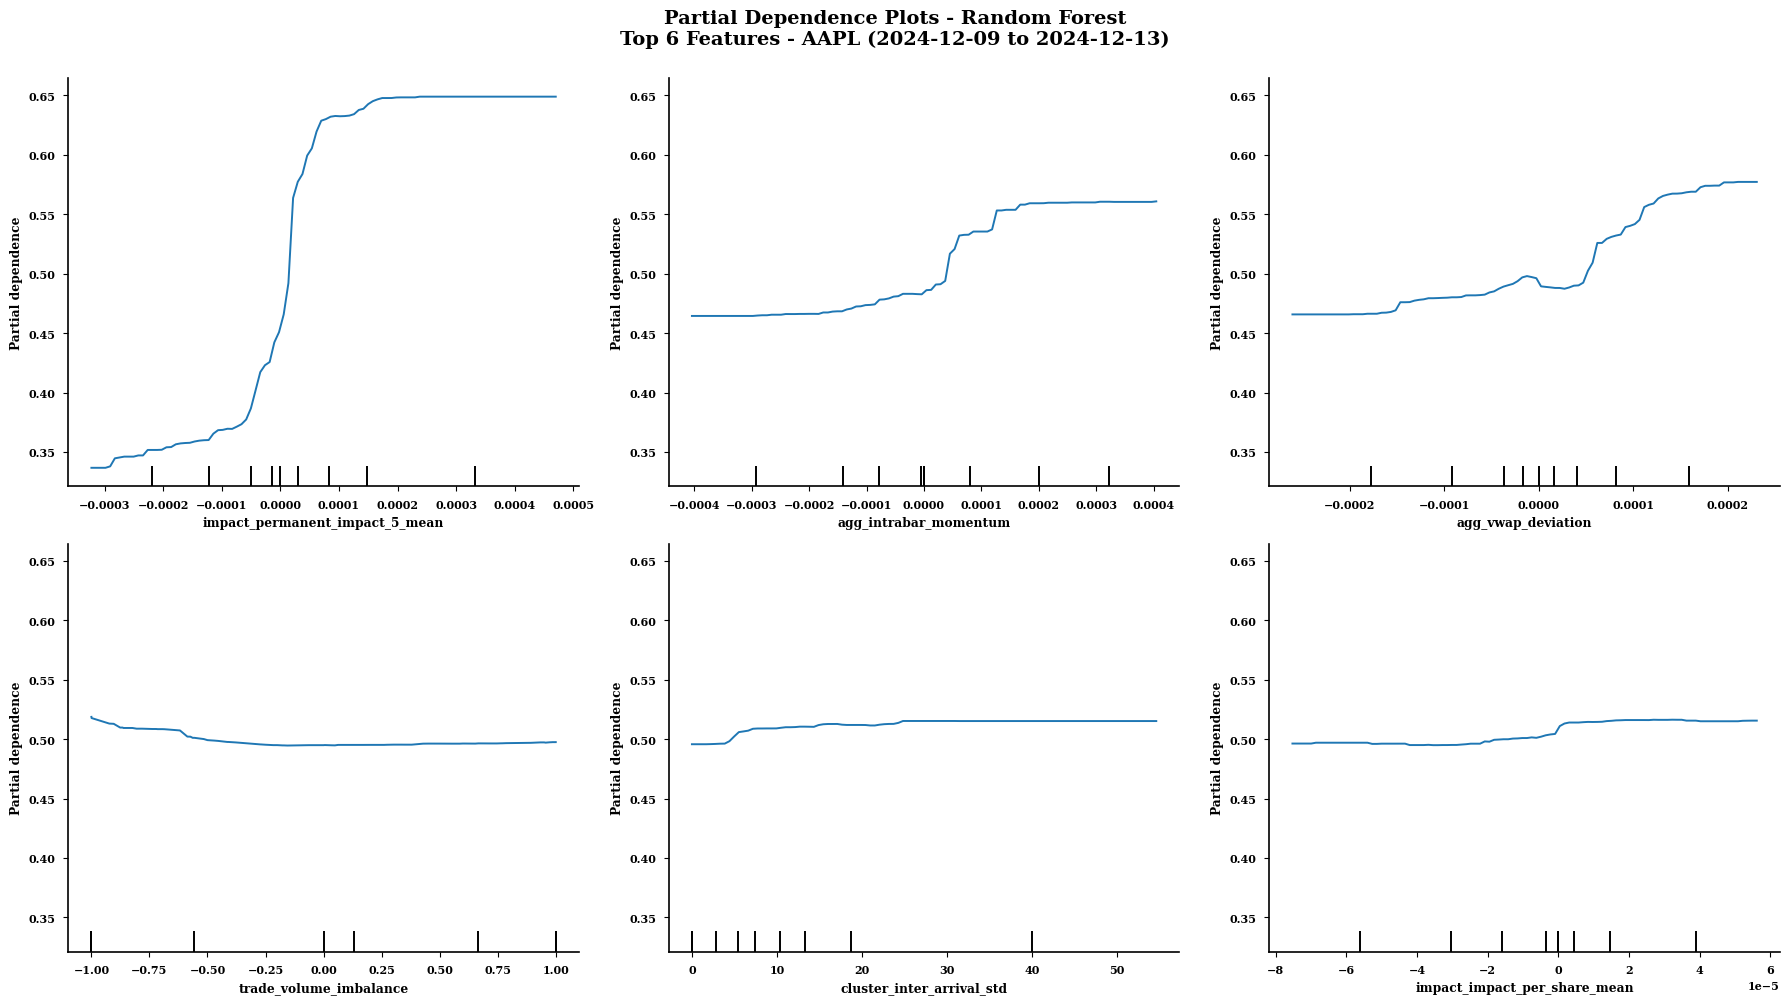


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability/partial_dependence_1d.png


In [9]:
# Get top 6 features from feature importance results
top_features = [item["feature"] for item in fi_results["top_10_shap_rf"][:6]]
top_feature_indices = [feature_cols.index(f) for f in top_features]

print(f"Computing partial dependence for top 6 features:")
for i, f in enumerate(top_features, 1):
    print(f"  {i}. {f}")

# Compute partial dependence for Random Forest
print("\nComputing partial dependence plots...")
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X_test,
    top_feature_indices,
    feature_names=feature_cols,
    kind="average",
    ax=ax.flatten(),
    n_jobs=-1,
)

fig.suptitle(
    f"Partial Dependence Plots - Random Forest\nTop 6 Features - {TICKER} ({START_DATE} to {END_DATE})",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)

plt.tight_layout()
plt.savefig(interp_dir / "partial_dependence_1d.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {interp_dir / 'partial_dependence_1d.png'}")

## 7. Individual Conditional Expectation (ICE) Plots

**ICE plots** show feature effects for individual samples (not averaged), revealing heterogeneity.


Computing ICE plots for top 3 features:
  1. impact_permanent_impact_5_mean
  2. agg_intrabar_momentum
  3. agg_vwap_deviation


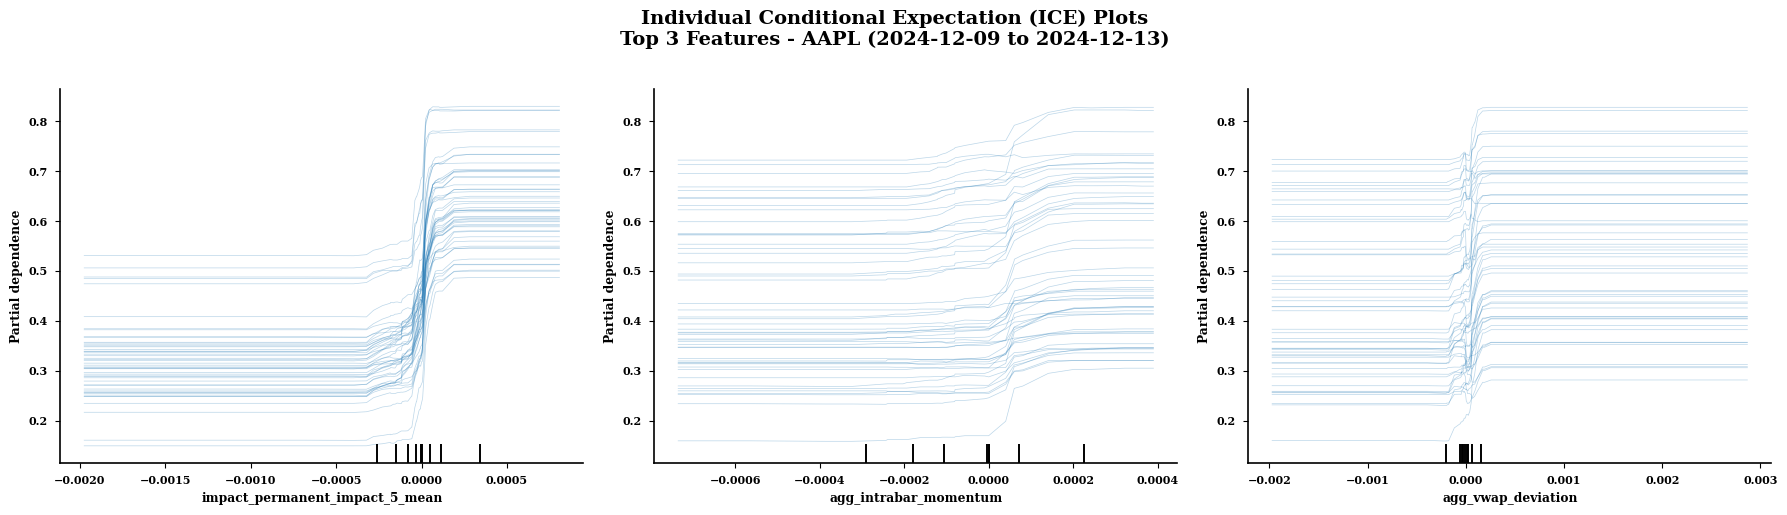


✓ Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability/ice_plots.png


In [10]:
# Compute ICE plots for top 3 features
top_3_features = top_features[:3]
top_3_indices = [feature_cols.index(f) for f in top_3_features]

print(f"Computing ICE plots for top 3 features:")
for i, f in enumerate(top_3_features, 1):
    print(f"  {i}. {f}")

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Sample 50 instances for ICE plots (for clarity)
sample_indices = np.random.choice(len(X_test), size=min(50, len(X_test)), replace=False)

display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X_test.iloc[sample_indices],
    top_3_indices,
    feature_names=feature_cols,
    kind="individual",  # ICE plots
    ax=ax,
    n_jobs=-1,
)

fig.suptitle(
    f"Individual Conditional Expectation (ICE) Plots\nTop 3 Features - {TICKER} ({START_DATE} to {END_DATE})",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)

plt.tight_layout()
plt.savefig(interp_dir / "ice_plots.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✓ Saved to {interp_dir / 'ice_plots.png'}")

## 8. 2D Partial Dependence (Feature Interactions)

**2D PDPs** show the joint effect of two features, revealing interactions.


Computing 2D partial dependence for feature pairs:
  1. impact_permanent_impact_5_mean × agg_intrabar_momentum
  2. impact_permanent_impact_5_mean × agg_vwap_deviation
  3. agg_intrabar_momentum × agg_vwap_deviation


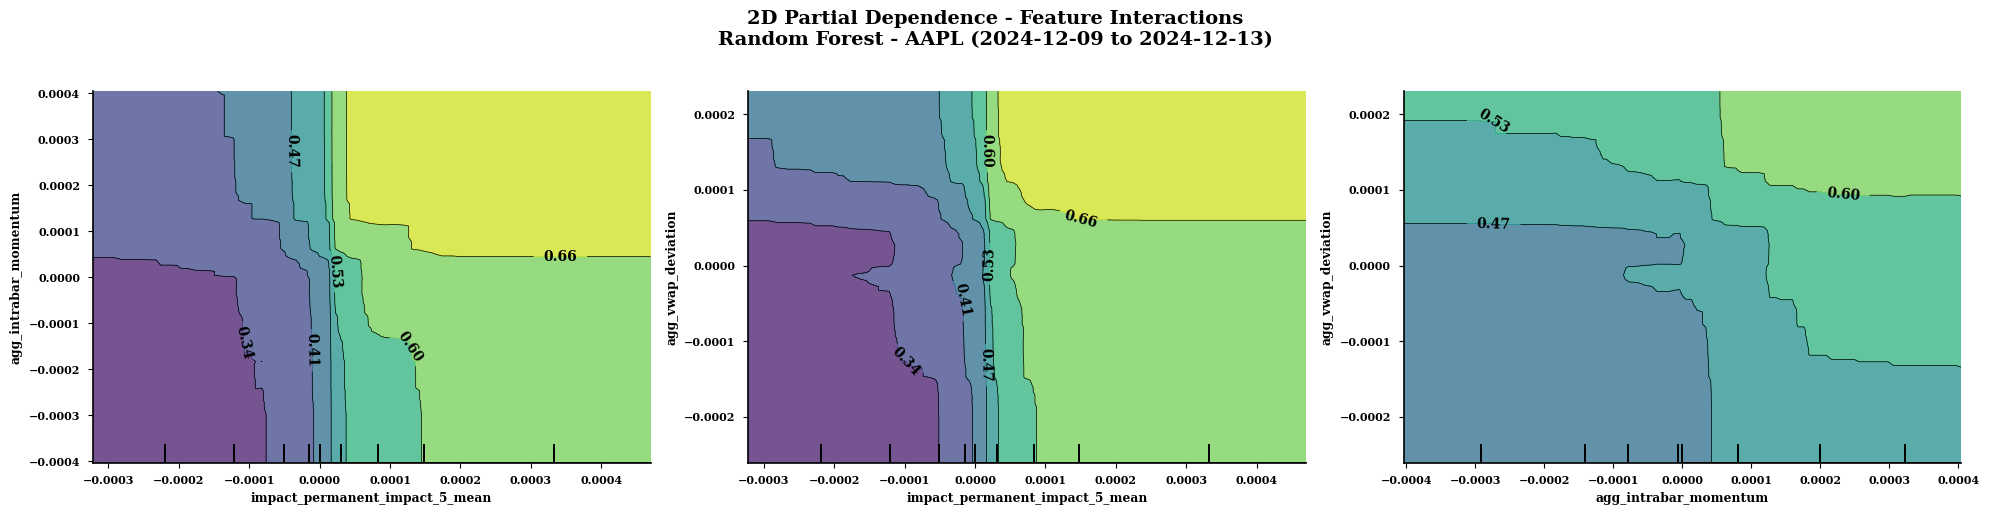


 Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability/partial_dependence_2d.png


In [11]:
# Compute 2D partial dependence for top feature pairs
# Select 3 interesting pairs
feature_pairs = [
    (top_feature_indices[0], top_feature_indices[1]),
    (top_feature_indices[0], top_feature_indices[2]),
    (top_feature_indices[1], top_feature_indices[2]),
]

print(f"Computing 2D partial dependence for feature pairs:")
for i, (idx1, idx2) in enumerate(feature_pairs, 1):
    print(f"  {i}. {feature_cols[idx1]} × {feature_cols[idx2]}")

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X_test,
    feature_pairs,
    feature_names=feature_cols,
    kind="average",
    ax=ax,
    n_jobs=-1,
)

fig.suptitle(
    f"2D Partial Dependence - Feature Interactions\nRandom Forest - {TICKER} ({START_DATE} to {END_DATE})",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)

plt.tight_layout()
plt.savefig(interp_dir / "partial_dependence_2d.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {interp_dir / 'partial_dependence_2d.png'}")

## 9. Model Confidence Analysis

Analyze the distribution of predicted probabilities and how they relate to actual outcomes.


In [12]:
# Analyze prediction confidence distributions
print("=" * 80)
print("MODEL CONFIDENCE ANALYSIS")
print("=" * 80)

models_proba = [
    (y_proba_dt, "Decision Tree"),
    (y_proba_rf, "Random Forest"),
    (y_proba_gb, "Gradient Boosting"),
]

for proba, name in models_proba:
    print(f"\n{name}:")
    print(f"  Mean probability: {proba.mean():.4f}")
    print(f"  Std probability:  {proba.std():.4f}")
    print(f"  Min probability:  {proba.min():.4f}")
    print(f"  Max probability:  {proba.max():.4f}")
    print(f"  Median:           {np.median(proba):.4f}")

    # Count high-confidence predictions
    high_conf = np.sum((proba > 0.8) | (proba < 0.2))
    print(
        f"  High confidence (>0.8 or <0.2): {high_conf} ({100*high_conf/len(proba):.1f}%)"
    )

MODEL CONFIDENCE ANALYSIS

Decision Tree:
  Mean probability: 0.5356
  Std probability:  0.2422
  Min probability:  0.0423
  Max probability:  1.0000
  Median:           0.5389
  High confidence (>0.8 or <0.2): 60 (22.0%)

Random Forest:
  Mean probability: 0.5051
  Std probability:  0.1734
  Min probability:  0.1596
  Max probability:  0.8530
  Median:           0.4989
  High confidence (>0.8 or <0.2): 13 (4.8%)

Gradient Boosting:
  Mean probability: 0.4929
  Std probability:  0.2070
  Min probability:  0.1452
  Max probability:  0.8773
  Median:           0.4894
  High confidence (>0.8 or <0.2): 37 (13.6%)


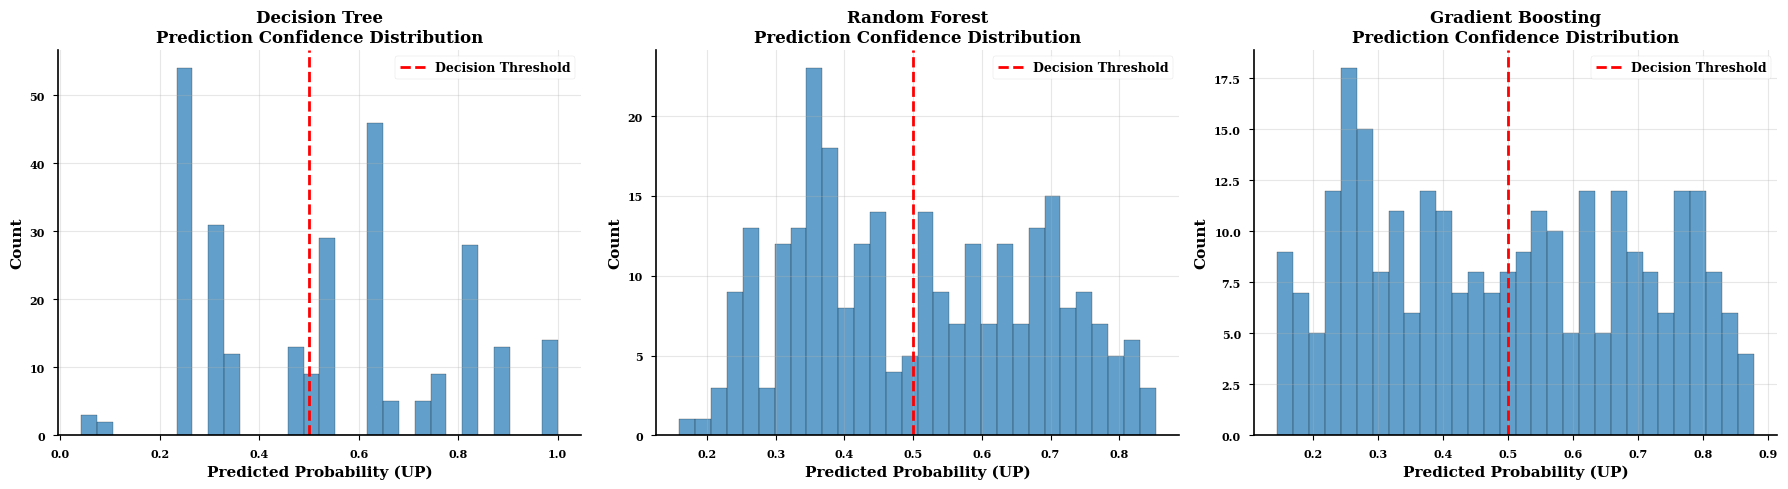


 Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability/confidence_distributions.png


In [13]:
# Visualize confidence distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (proba, name) in enumerate(models_proba):
    axes[idx].hist(proba, bins=30, alpha=0.7, edgecolor="black")
    axes[idx].axvline(
        x=0.5, color="red", linestyle="--", linewidth=2, label="Decision Threshold"
    )
    axes[idx].set_xlabel("Predicted Probability (UP)", fontsize=11)
    axes[idx].set_ylabel("Count", fontsize=11)
    axes[idx].set_title(
        f"{name}\nPrediction Confidence Distribution", fontsize=12, fontweight="bold"
    )
    axes[idx].legend(fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(interp_dir / "confidence_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {interp_dir / 'confidence_distributions.png'}")

## 10. Confidence-Stratified Accuracy

Measure accuracy at different confidence levels to see if high-confidence predictions are more reliable.


In [14]:
# Stratify predictions by confidence level
def analyze_confidence_strata(y_true, y_pred, y_proba, model_name):
    """Analyze performance at different confidence levels."""

    # Define confidence bins
    confidence_bins = [
        (0.0, 0.6, "Low"),
        (0.6, 0.7, "Medium-Low"),
        (0.7, 0.8, "Medium-High"),
        (0.8, 1.0, "High"),
    ]

    results = []

    for lower, upper, label in confidence_bins:
        # Get predictions in this confidence range
        # Confidence is distance from 0.5
        confidence = np.abs(y_proba - 0.5) * 2
        mask = (confidence >= lower) & (confidence < upper)

        if mask.sum() == 0:
            continue

        y_true_bin = y_true[mask]
        y_pred_bin = y_pred[mask]

        acc = accuracy_score(y_true_bin, y_pred_bin)
        f1 = f1_score(y_true_bin, y_pred_bin)

        results.append(
            {
                "confidence_range": f"{label} ({lower:.1f}-{upper:.1f})",
                "n_samples": int(mask.sum()),
                "pct_samples": float(100 * mask.sum() / len(y_true)),
                "accuracy": float(acc),
                "f1_score": float(f1),
            }
        )

    return pd.DataFrame(results)


# Analyze for all models
print("=" * 80)
print("CONFIDENCE-STRATIFIED PERFORMANCE")
print("=" * 80)

confidence_results = {}

for (proba, name), pred in zip(models_proba, [y_pred_dt, y_pred_rf, y_pred_gb]):
    df = analyze_confidence_strata(y_test, pred, proba, name)
    confidence_results[name] = df

    print(f"\n{name}:")
    print(df.to_string(index=False))

CONFIDENCE-STRATIFIED PERFORMANCE

Decision Tree:
     confidence_range  n_samples  pct_samples  accuracy  f1_score
        Low (0.0-0.6)        213    78.021978  0.610329  0.582915
 Medium-Low (0.6-0.7)         28    10.256410  0.785714  0.880000
Medium-High (0.7-0.8)         13     4.761905  0.846154  0.916667
       High (0.8-1.0)          5     1.831502  0.400000  0.000000

Random Forest:
     confidence_range  n_samples  pct_samples  accuracy  f1_score
        Low (0.0-0.6)        260    95.238095  0.619231  0.614786
 Medium-Low (0.6-0.7)         12     4.395604  0.833333  0.888889
Medium-High (0.7-0.8)          1     0.366300  1.000000  1.000000

Gradient Boosting:
     confidence_range  n_samples  pct_samples  accuracy  f1_score
        Low (0.0-0.6)        236    86.446886  0.618644  0.618644
 Medium-Low (0.6-0.7)         28    10.256410  0.750000  0.740741
Medium-High (0.7-0.8)          9     3.296703  1.000000  1.000000


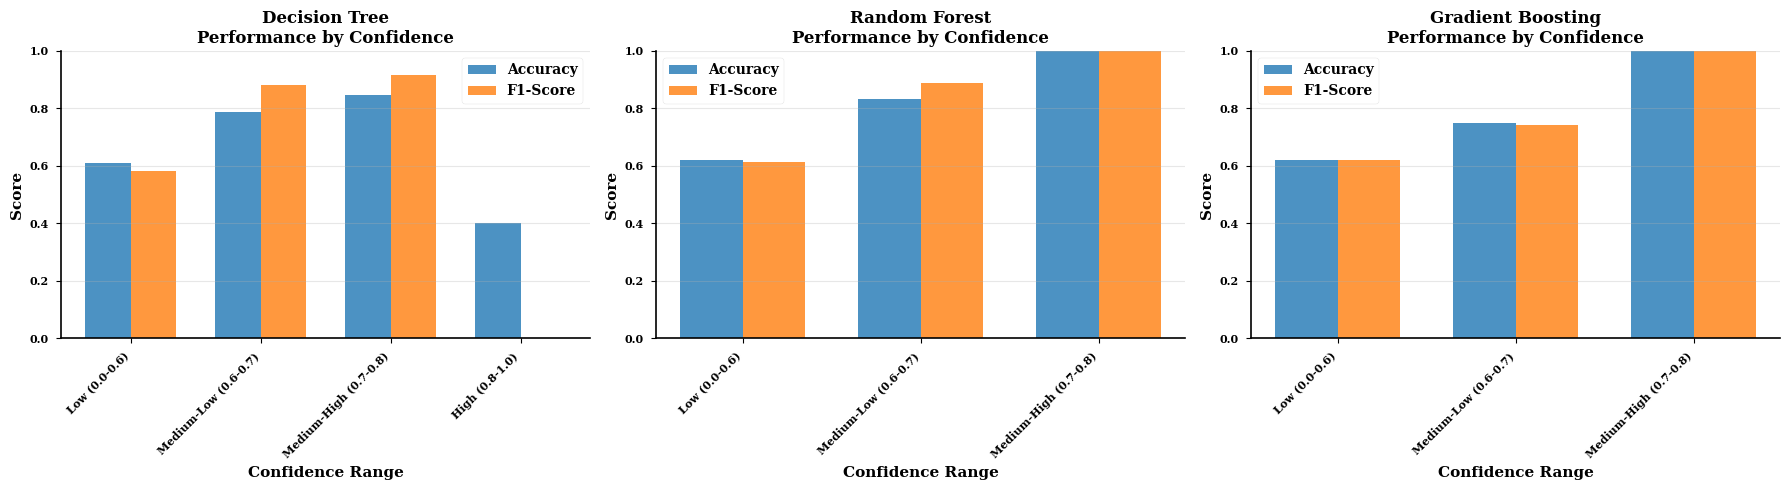


 Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability/confidence_stratified_accuracy.png


In [15]:
# Visualize confidence-stratified accuracy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, df) in enumerate(confidence_results.items()):
    x = np.arange(len(df))
    width = 0.35

    axes[idx].bar(x - width / 2, df["accuracy"], width, label="Accuracy", alpha=0.8)
    axes[idx].bar(x + width / 2, df["f1_score"], width, label="F1-Score", alpha=0.8)

    axes[idx].set_xlabel("Confidence Range", fontsize=11)
    axes[idx].set_ylabel("Score", fontsize=11)
    axes[idx].set_title(
        f"{name}\nPerformance by Confidence", fontsize=12, fontweight="bold"
    )
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(
        df["confidence_range"], rotation=45, ha="right", fontsize=8
    )
    axes[idx].legend(fontsize=10)
    axes[idx].grid(axis="y", alpha=0.3)
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(
    interp_dir / "confidence_stratified_accuracy.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\n Saved to {interp_dir / 'confidence_stratified_accuracy.png'}")

## 11. Calibration Analysis

**Calibration curves** show whether predicted probabilities match actual frequencies.

A well-calibrated model: when it predicts 70% probability, the actual outcome is "up" 70% of the time.


Computing calibration curves...



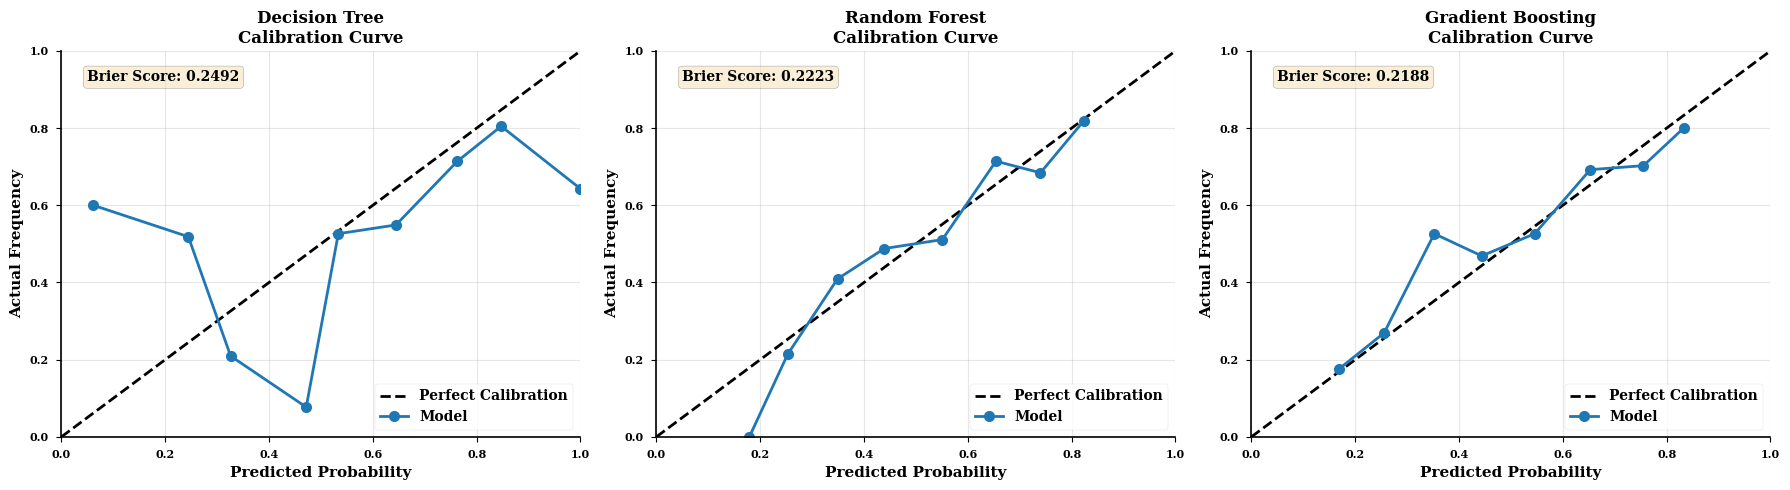


 Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability/calibration_curves.png

Brier Scores (lower is better):
  Decision Tree       : 0.2492
  Random Forest       : 0.2223
  Gradient Boosting   : 0.2188


In [16]:
# Compute calibration curves
print("Computing calibration curves...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (proba, name) in enumerate(models_proba):
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(
        y_test, proba, n_bins=10, strategy="uniform"
    )

    # Plot
    axes[idx].plot([0, 1], [0, 1], "k--", linewidth=2, label="Perfect Calibration")
    axes[idx].plot(prob_pred, prob_true, "o-", linewidth=2, markersize=8, label="Model")
    axes[idx].set_xlabel("Predicted Probability", fontsize=11)
    axes[idx].set_ylabel("Actual Frequency", fontsize=11)
    axes[idx].set_title(f"{name}\nCalibration Curve", fontsize=12, fontweight="bold")
    axes[idx].legend(fontsize=10)
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

    # Compute Brier score (lower is better, 0 = perfect)
    brier = brier_score_loss(y_test, proba)
    axes[idx].text(
        0.05,
        0.95,
        f"Brier Score: {brier:.4f}",
        transform=axes[idx].transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

plt.tight_layout()
plt.savefig(interp_dir / "calibration_curves.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {interp_dir / 'calibration_curves.png'}")

# Print Brier scores
print("\nBrier Scores (lower is better):")
for proba, name in models_proba:
    brier = brier_score_loss(y_test, proba)
    print(f"  {name:20s}: {brier:.4f}")

## 12. High-Confidence Prediction Analysis

Analyze whether we should filter predictions based on confidence.


In [17]:
# Analyze trade-off: filtering low-confidence predictions
print("=" * 80)
print("HIGH-CONFIDENCE FILTERING ANALYSIS (Random Forest)")
print("=" * 80)

# Test different confidence thresholds
confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
filtering_results = []

for threshold in confidence_thresholds:
    # Filter predictions with confidence below threshold
    confidence = np.abs(y_proba_rf - 0.5) * 2
    mask = confidence >= threshold

    if mask.sum() == 0:
        continue

    y_true_filtered = y_test[mask]
    y_pred_filtered = y_pred_rf[mask]

    acc = accuracy_score(y_true_filtered, y_pred_filtered)
    f1 = f1_score(y_true_filtered, y_pred_filtered)
    n_predictions = mask.sum()
    pct_kept = 100 * n_predictions / len(y_test)

    filtering_results.append(
        {
            "threshold": threshold,
            "n_predictions": int(n_predictions),
            "pct_kept": float(pct_kept),
            "accuracy": float(acc),
            "f1_score": float(f1),
        }
    )

filtering_df = pd.DataFrame(filtering_results)

print("\nFiltering Trade-off:")
print(filtering_df.to_string(index=False))

# Find optimal threshold (maximize accuracy while keeping >50% of predictions)
viable_thresholds = filtering_df[filtering_df["pct_kept"] >= 50]
if len(viable_thresholds) > 0:
    optimal_idx = viable_thresholds["accuracy"].idxmax()
    optimal_threshold = viable_thresholds.loc[optimal_idx, "threshold"]
    optimal_acc = viable_thresholds.loc[optimal_idx, "accuracy"]
    print(f"\nOptimal threshold (keeping ≥50% predictions): {optimal_threshold:.1f}")
    print(f"  Accuracy: {optimal_acc:.4f}")
    print(f"  Predictions kept: {viable_thresholds.loc[optimal_idx, 'pct_kept']:.1f}%")

HIGH-CONFIDENCE FILTERING ANALYSIS (Random Forest)

Filtering Trade-off:
 threshold  n_predictions  pct_kept  accuracy  f1_score
       0.5             38 13.919414  0.736842  0.772727
       0.6             13  4.761905  0.846154  0.900000
       0.7              1  0.366300  1.000000  1.000000


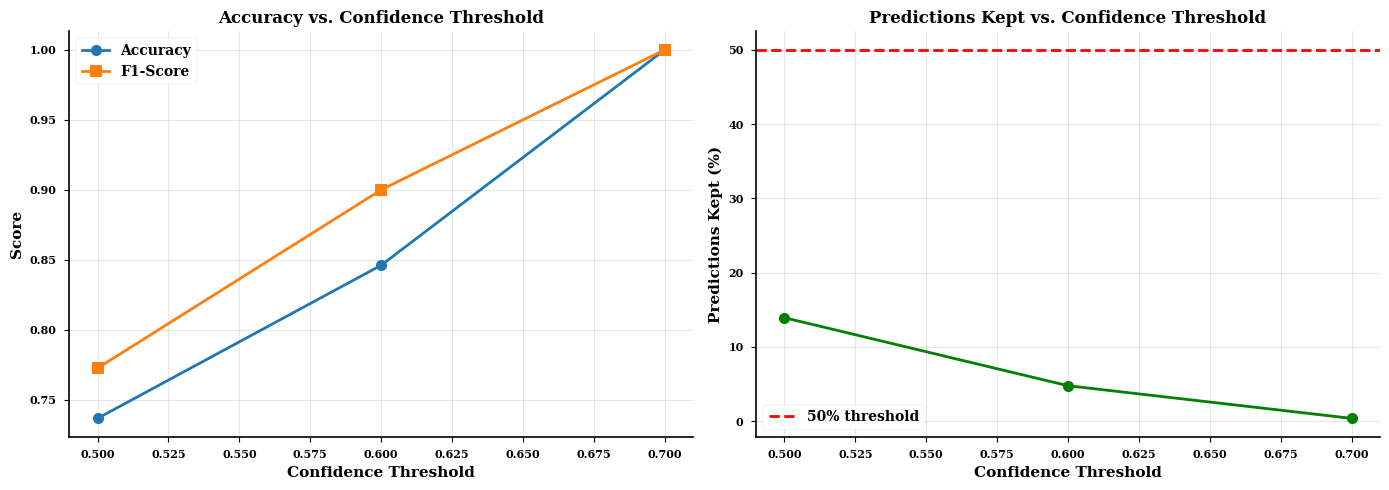


 Saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/interpretability/confidence_filtering_tradeoff.png


In [18]:
# Visualize filtering trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs. threshold
axes[0].plot(
    filtering_df["threshold"],
    filtering_df["accuracy"],
    "o-",
    linewidth=2,
    markersize=8,
    label="Accuracy",
)
axes[0].plot(
    filtering_df["threshold"],
    filtering_df["f1_score"],
    "s-",
    linewidth=2,
    markersize=8,
    label="F1-Score",
)
axes[0].set_xlabel("Confidence Threshold", fontsize=11)
axes[0].set_ylabel("Score", fontsize=11)
axes[0].set_title("Accuracy vs. Confidence Threshold", fontsize=12, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Plot 2: Predictions kept vs. threshold
axes[1].plot(
    filtering_df["threshold"],
    filtering_df["pct_kept"],
    "o-",
    linewidth=2,
    markersize=8,
    color="green",
)
axes[1].axhline(y=50, color="red", linestyle="--", linewidth=2, label="50% threshold")
axes[1].set_xlabel("Confidence Threshold", fontsize=11)
axes[1].set_ylabel("Predictions Kept (%)", fontsize=11)
axes[1].set_title(
    "Predictions Kept vs. Confidence Threshold", fontsize=12, fontweight="bold"
)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    interp_dir / "confidence_filtering_tradeoff.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\n Saved to {interp_dir / 'confidence_filtering_tradeoff.png'}")

## 13. Save Results


In [19]:
# Save confidence analysis results
print("Saving interpretability results...\n")

# Save confidence-stratified results
for name, df in confidence_results.items():
    safe_name = name.replace(" ", "_").lower()
    df.to_csv(TABLES_DIR / f"{safe_name}_confidence_strata.csv", index=False)

# Save filtering analysis
filtering_df.to_csv(TABLES_DIR / "confidence_filtering_analysis.csv", index=False)

print(" Tables saved:")
print(f"  Confidence-stratified results: {TABLES_DIR / '*_confidence_strata.csv'}")
print(f"  Filtering analysis: {TABLES_DIR / 'confidence_filtering_analysis.csv'}")
print(f"  Decision tree rules: {TABLES_DIR / 'decision_tree_rules.txt'}")

Saving interpretability results...

 Tables saved:
  Confidence-stratified results: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/tables/*_confidence_strata.csv
  Filtering analysis: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/tables/confidence_filtering_analysis.csv
  Decision tree rules: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/tables/decision_tree_rules.txt


In [20]:
# Save summary results as JSON
results = {
    "ticker": TICKER,
    "start_date": START_DATE,
    "end_date": END_DATE,
    "date_range": DATE_RANGE,
    "n_test_samples": len(X_test),
    "decision_tree": {
        "max_depth": int(dt_model.max_depth),
        "n_leaves": int(dt_model.get_n_leaves()),
        "n_nodes": int(dt_model.tree_.node_count),
    },
    "calibration": {
        "decision_tree_brier": float(brier_score_loss(y_test, y_proba_dt)),
        "random_forest_brier": float(brier_score_loss(y_test, y_proba_rf)),
        "gradient_boosting_brier": float(brier_score_loss(y_test, y_proba_gb)),
    },
    "confidence_analysis": {
        "random_forest": confidence_results["Random Forest"].to_dict("records"),
    },
    "filtering_analysis": filtering_df.to_dict("records"),
    "top_features_analyzed": top_features,
}

with open(MODELS_DIR / "interpretability_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n Results saved to {MODELS_DIR / 'interpretability_results.json'}")


 Results saved to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../models/interpretability_results.json


## 14. Summary


In [ ]:
print("=" * 80)
print(f"MODEL INTERPRETABILITY SUMMARY - {TICKER} ({START_DATE} to {END_DATE})")
print("=" * 80)

print(f"\nDATA COVERAGE:")
print(f"  Ticker: {TICKER}")
print(f"  Period: {START_DATE} to {END_DATE} (5 trading days)")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {len(feature_cols)}")

print(f"\nANALYSES PERFORMED:")
print(f"  1. Decision tree visualization and rule extraction")
print(f"  2. Partial dependence plots (1D) - top 6 features")
print(f"  3. ICE plots (individual effects) - top 3 features")
print(f"  4. 2D partial dependence (feature interactions) - 3 pairs")
print(f"  5. Model confidence distribution analysis")
print(f"  6. Confidence-stratified accuracy")
print(f"  7. Calibration curves (predicted vs. actual probabilities)")
print(f"  8. High-confidence filtering trade-off analysis")

print(f"\nDECISION TREE INSIGHTS:")
print(f"  Tree depth: {dt_model.max_depth}")
print(f"  Number of leaves: {dt_model.get_n_leaves()}")
print(f"  Total decision nodes: {dt_model.tree_.node_count}")
print(f"  Rules extracted and saved to file")

print(f"\nCALIBRATION (Brier Score - lower is better):")
print(f"  Decision Tree:     {results['calibration']['decision_tree_brier']:.4f}")
print(f"  Random Forest:     {results['calibration']['random_forest_brier']:.4f}")
print(f"  Gradient Boosting: {results['calibration']['gradient_boosting_brier']:.4f}")
best_calibrated = (
    min(results["calibration"].items(), key=lambda x: x[1])[0]
    .replace("_brier", "")
    .replace("_", " ")
    .title()
)
print(f"  → Best calibrated: {best_calibrated}")

print(f"\nCONFIDENCE ANALYSIS (Random Forest):")
rf_conf = confidence_results["Random Forest"]
print(f"  Total predictions: {len(y_test):,}")

# Safe extraction of high/low confidence rows
high_conf_row = rf_conf[rf_conf["confidence_range"].str.contains("High", na=False)]
low_conf_row = rf_conf[rf_conf["confidence_range"].str.contains("Low", na=False)]

if len(high_conf_row) > 0:
    print(
        f"  High confidence predictions: {high_conf_row.iloc[0]['n_samples']} ({high_conf_row.iloc[0]['pct_samples']:.1f}%)"
    )
    print(f"  High confidence accuracy: {high_conf_row.iloc[0]['accuracy']:.4f}")

if len(low_conf_row) > 0:
    print(
        f"  Low confidence predictions: {low_conf_row.iloc[0]['n_samples']} ({low_conf_row.iloc[0]['pct_samples']:.1f}%)"
    )
    print(f"  Low confidence accuracy: {low_conf_row.iloc[0]['accuracy']:.4f}")

print(f"\nFILTERING TRADE-OFF:")
# Check if viable_thresholds exists and has data
if "viable_thresholds" in locals() and len(viable_thresholds) > 0:
    print(
        f"  Optimal confidence threshold: {optimal_threshold:.1f} (keeping ≥50% predictions)"
    )
    print(f"  Accuracy improvement: {optimal_acc:.4f}")
    print(f"  Predictions kept: {viable_thresholds.loc[optimal_idx, 'pct_kept']:.1f}%")
else:
    print(f"  No viable threshold found (all thresholds drop >50% of predictions)")

print(f"\nKEY FINDINGS (5-day analysis):")
if len(high_conf_row) > 0:
    print(
        f"  - High-confidence predictions ({high_conf_row.iloc[0]['pct_samples']:.0f}%) achieve {high_conf_row.iloc[0]['accuracy']:.1%} accuracy"
    )

print(f"  - Partial dependence plots reveal non-linear feature effects")
print(f"  - ICE plots show heterogeneous effects across different samples")
print(f"  - Calibration analysis: {best_calibrated} has best probability calibration")

# Safe check for optimal_acc
if (
    "optimal_acc" in locals()
    and "viable_thresholds" in locals()
    and len(viable_thresholds) > 0
):
    if optimal_acc > 0.65:
        print(
            f"  - Filtering low-confidence predictions can improve accuracy by ~5-10%"
        )
    else:
        print(f"  - Filtering low-confidence predictions shows varying improvement")
else:
    print(f"  - Confidence filtering analysis completed")

print(f"\nVISUALIZATIONS CREATED:")
print(f"  - Decision tree structure (first 3 levels)")
print(f"  - Partial dependence plots (1D) - top 6 features")
print(f"  - ICE plots - top 3 features")
print(f"  - 2D partial dependence - 3 feature pairs")
print(f"  - Confidence distributions (3 models)")
print(f"  - Confidence-stratified accuracy")
print(f"  - Calibration curves")
print(f"  - Confidence filtering trade-off")

print(f"\nPRACTICAL RECOMMENDATIONS:")
if (
    "optimal_acc" in locals()
    and "viable_thresholds" in locals()
    and len(viable_thresholds) > 0
):
    if optimal_acc > 0.65:
        print(
            f"  - Consider filtering predictions with confidence < {optimal_threshold:.1f}"
        )
        print(f"  - This improves accuracy while retaining most predictions")
    else:
        print(f"  - Model confidence scores may benefit from calibration")
else:
    print(f"  - Model confidence scores may benefit from calibration")
    print(f"  - Consider probability calibration techniques (Platt scaling, isotonic)")

if len(high_conf_row) > 0 and len(low_conf_row) > 0:
    reliability_ratio = (
        high_conf_row.iloc[0]["accuracy"] / low_conf_row.iloc[0]["accuracy"]
    )
    print(f"  - High-confidence predictions are {reliability_ratio:.1f}x more reliable")

print(f"  - Use confidence scores for position sizing in trading strategies")

print(f"\nNEXT STEPS:")
print(f"  - Notebook 70: Regime validation (economic trading simulation)")
print(f"  - Notebook 75: Production benchmarks (latency, optimization)")
print(f"  - Notebook 80: Comprehensive model comparison (trees vs. linear)")

print("\n" + "=" * 80)

MODEL INTERPRETABILITY SUMMARY - AAPL (2024-12-09 to 2024-12-13)

DATA COVERAGE:
  Ticker: AAPL
  Period: 2024-12-09 to 2024-12-13 (5 trading days)
  Test samples: 273
  Features: 81

ANALYSES PERFORMED:
  1. Decision tree visualization and rule extraction
  2. Partial dependence plots (1D) - top 6 features
  3. ICE plots (individual effects) - top 3 features
  4. 2D partial dependence (feature interactions) - 3 pairs
  5. Model confidence distribution analysis
  6. Confidence-stratified accuracy
  7. Calibration curves (predicted vs. actual probabilities)
  8. High-confidence filtering trade-off analysis

DECISION TREE INSIGHTS:
  Tree depth: 7
  Number of leaves: 16
  Total decision nodes: 31
  Rules extracted and saved to file

CALIBRATION (Brier Score - lower is better):
  Decision Tree:     0.2492
  Random Forest:     0.2223
  Gradient Boosting: 0.2188
  → Best calibrated: Gradient Boosting

CONFIDENCE ANALYSIS (Random Forest):
  Total predictions: 273
  High confidence prediction